# WikiPedia Detox Analysis

Learners and transformations in nimbusml can be used in sklearn pipelines together with scikit learn elements. In this example, we develop a scikit learn pipeline with nimbusml featurizer and then replace all scikit learn elements with nimbusml ones.

We use the WikiPedia Detox dataset (https://meta.wikimedia.org/wiki/Research:Detox/Data_Release) to develop a binary classifier to identify if a comment on the webpage is a personal attack. The original input data includes a corpus of 95 million article talks, while in this example, we use a small sample (100 rows) for training and testing.

2 models/pipelines are created:
1. A sklearn pipeline with nimbusml NGramFeaturizer, sklearn Truncated SVD and sklearn LogisticRegression
2. A nimbusml pipeline with nimbusml NGramFeaturizer, nimbusml WordEmbedding and nimbusml FastLinearBinaryClassifier trained with nimbusml FileDataStream.

A sample of the dataset is presented in the following table:

|Sentiment|SentimentText|
|-----|-----------------|
|1|==RUDE== Dude, you are rude upload that carl picture back, or else.|
|1|== OK! ==  IM GOING TO VANDALIZE WILD ONES WIKI THEN!!!|
|1|  Stop trolling, zapatancas, calling me a liar merely demonstartes that you arer Zapatancas...|

For simplicity, we just use the "comment" column as the input data and the "Label" column as the label.

## Model 1: Sklearn Pipeline with nimbusml Element 

In this example, we create a sklearn pipeline with nimbusml NGramFeaturizer, sklearn Truncated SVD and sklearn LogisticRegression. Similarly to the TfidfVectorizer(), our NGramFeaturizer creates the the same bag of counts of sequences and weights it using TF-IDF method. 
The nimbusml featurizer works as well in a sklearn pipeline. We can just swap out the first TfidfVectorizer() with our NGramFeaturizer() in the sklearn pipeline.

In [1]:
import numpy as np
import time
import sklearn
import os
from IPython.display import display
import matplotlib.pyplot as plt
import pandas as pd
from nimbusml.datasets import get_dataset
from nimbusml.feature_extraction.text.extractor import Ngram
from nimbusml.feature_extraction.text import NGramFeaturizer
from sklearn.feature_extraction.text import TfidfVectorizer as sklearn_TfidfVectorizer
from sklearn.decomposition import TruncatedSVD as sklearn_TruncatedSVD
from sklearn.pipeline import Pipeline as sklearn_ppl
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as sk_auc

In [2]:
def plot_roc_score(label_test, score):
    x, y, _ = roc_curve(label_test, score)
    roc_auc = sk_auc(x, y)
    
    plt.figure()
    lw = 2
    plt.plot(x, y, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
# Get input data file path from the package
Train_file = get_dataset('wiki_detox_train').as_filepath()
Test_file = get_dataset('wiki_detox_test').as_filepath()
print(os.path.basename(Train_file))
print(os.path.basename(Test_file))

train-250.wikipedia.sample.tsv
test.wikipedia.sample.tsv


In [4]:
# Loading data
# dataTrain = pd.read_csv(Train_file, encoding="ISO-8859-1", sep = "\t") # Error under py2.7 but not 3.6
dataTrain = pd.read_csv(Train_file, sep = "\t")
dataTest = pd.read_csv(Test_file, sep = "\t")

dataTrain.head()

,Sentiment,SentimentText
0,1,"==RUDE== Dude, you are rude upload that carl..."
1,1,== OK! == IM GOING TO VANDALIZE WILD ONES W...
2,1,"Stop trolling, zapatancas, calling me a lia..."
3,1,==You're cool== You seem like a really cool...
4,1,::::: Why are you threatening me? I'm not bei...


In [5]:
# Creating pipeline
t0 = time.time()

featurizer = NGramFeaturizer(word_feature_extractor=Ngram())
svd = sklearn_TruncatedSVD(random_state = 1, n_components = 400)
lr = sklearn.linear_model.LogisticRegression()
sk_ppl = sklearn_ppl([("featurizer",featurizer),
                     ("svd",svd),
                     ("lr",lr)]) 

In [6]:
# Training
sk_ppl.fit(dataTrain[["SentimentText"]], dataTrain["Sentiment"]) #UPDATE ONCE SERIES IS SUPPORTED FOR X!

train_time_sec = time.time() - t0
print("Training time: " + str(round(train_time_sec,2)) + "s")

Training time: 8.68s


In [7]:
# Testing
t0 = time.time()
Y_pred = sk_ppl.predict(dataTest["SentimentText"].to_frame()) #UPDATE ONCE SERIES IS SUPPORTED FOR X!
Y_prob = sk_ppl.predict_proba(dataTest["SentimentText"].to_frame())#UPDATE ONCE SERIES IS SUPPORTED FOR X!
test_time_sec = time.time() - t0
print("Testing time: " + str(round(test_time_sec,2)) + "s")

Testing time: 0.87s


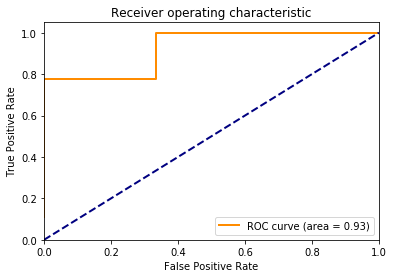

In [8]:
# Plot roc
plot_roc_score(dataTest["Sentiment"], Y_prob[:,1]);

## Model 2: Pure NimbusML with Schema

In this example, we will create a pure nimbusml pipeline with only nimbusml elements, i.e. nimbusml NGramFeaturizer, nimbusml WordEmbedding and nimbusml FastLinearBinaryClassifier. We will process the data using nimbusml DataFileStream instead of pandas dataframe.

In [9]:
import time
from nimbusml.linear_model import FastLinearBinaryClassifier
from nimbusml.feature_extraction.text import WordEmbedding
from nimbusml import Pipeline, FileDataStream

The WordEmbedding() is based on a pretrained DNN model to generate word embeddings for given corps. In this example, we use the 'GloVe50D' as the embedding model. Available options are: 'GloVe50D', 'GloVe100D', 'GloVe200D', 'GloVe300D', 'GloVeTwitter25D', 'GloVeTwitter50D', 'GloVeTwitter100D', 'GloVeTwitter200D', 'FastTextWikipedia300D', and 'Sswe'. The output is 100 dimensional and compared with the "vanilla" ngram models, the features are much more meaningful. Users can also play with other options, such as the Sentiment-specific word embedding (SSWE), which incorporates sentiment information into the features. It's proved to be useful in various sentiment analysis tasks. 

The WordEmbedding() takes as input a sequence of words: 

                                         ["This", "is", "a", "sentence"].

Therefore, we need to convert the raw input "This is a sentence" into the format that SsweEmbedding requires. And that can be done using the NGramFeaturizer() and setting output_tokens = True. Let's see a short example.

In [10]:
featurizer = NGramFeaturizer(word_feature_extractor=Ngram(), output_tokens = True)
glove = WordEmbedding(columns = "SentimentText_TransformedText", model_kind = 'Sswe') # indicating we are using the output token column  
ppl = Pipeline([featurizer,glove])
ppl.fit_transform(dataTrain[["SentimentText"]])[0:3] #UPDATE WHEN SUPPORT SERIES!

,SentimentText.!,SentimentText.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!,"SentimentText.""","SentimentText.""(referenced","SentimentText."">100","SentimentText.""accidental","SentimentText.""all","SentimentText.""anti-islamic","SentimentText.""as","SentimentText.""big",...,SentimentText_TransformedText.90,SentimentText_TransformedText.91,SentimentText_TransformedText.92,SentimentText_TransformedText.93,SentimentText_TransformedText.94,SentimentText_TransformedText.95,SentimentText_TransformedText.96,SentimentText_TransformedText.97,SentimentText_TransformedText.98,SentimentText_TransformedText.99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.370133,-1.014376,0.554087,-0.225560,-0.366204,-0.453244,0.332854,0.422627,-1.044630,1.629947
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.363716,-1.017529,0.044500,0.273996,-0.132468,-0.296792,0.828727,0.502382,-1.047630,1.490451
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.264653,-0.797380,0.084775,0.081575,-0.100109,-0.291873,0.650487,0.917782,-1.071705,1.575903


The first part of the output is the output from the NGramFeaturizer(), i.e. the weighted word/sequence count with names "comment.[word]". If setting **output_tokens = True**, one more extra column will be generated by NGramFeaturizer() with the list of words as required by sswe. The name of this output column is automatically renamed to "comment_TransformedText", which is the input column name plus "_TransformedText". 

This column used as input to SsweEmbedding, and it has a array of the words, e.g. ["This", "is", "a", "sentence"]. The output from the SsweEmbedding is named comment_TransformedText.* and has 100 dimensions.

Let's create a full pipeline for the classification problem.

In [11]:
# Generating data file stream    
data_stream_train = FileDataStream.read_csv(Train_file, sep='\t',collapse=False)
data_stream_test = FileDataStream.read_csv(Test_file, sep='\t',collapse=False)

In [12]:
# Creating pipeline
pipeline = Pipeline([
                       NGramFeaturizer(word_feature_extractor=Ngram(), output_tokens = True, columns = "SentimentText"),
                       WordEmbedding(columns = "SentimentText_TransformedText", model_kind = 'Sswe'),
                       FastLinearBinaryClassifier(feature = ["SentimentText_TransformedText"], label = 'Sentiment')  
                    ])

# Training
pipeline.fit(data_stream_train)  

Automatically adding a MinMax normalization transform, use 'norm=Warn' or 'norm=No' to turn this behavior off.
Using 8 threads to train.
Automatically choosing a check frequency of 8.
Auto-tuning parameters: maxIterations = 6024.
Auto-tuning parameters: L2 = 2.670256E-05.
Auto-tuning parameters: L1Threshold (L1/L2) = 0.25.
Using best model from iteration 1560.
Not training a calibrator because it is not needed.
Elapsed time: 00:00:02.5739867


In [13]:
# Testing
metrics, scores = pipeline.test(data_stream_test,'Sentiment', output_scores = True)
metrics

,AUC,Accuracy,Positive precision,Positive recall,Negative precision,Negative recall,Log-loss,Log-loss reduction,Test-set entropy (prior Log-Loss/instance),F1 Score,AUPRC
0,0.950617,0.888889,0.888889,0.888889,0.888889,0.888889,0.349515,65.048471,1,0.888889,0.964387


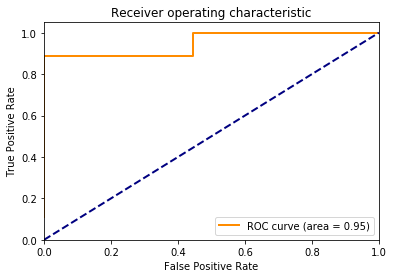

In [14]:
# Plot roc
plot_roc_score(dataTest["Sentiment"], scores["Probability"]);